#EDA

just taking an educated look at the data provided

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv("C:/Users/Ameer/Downloads/movie.csv")

In [3]:
data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [7]:
data.describe()

,label
count,40000.000000
mean,0.499525
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


#Data Cleaning

Consider common issues like missing,duplicate and inconsistent values, finally take a look at the various dependencies.

In [8]:

data.dropna(inplace=True)
for x in data.index:
  if data.loc[x,"label"] not in [0,1]:
    data.drop(x, inplace=True)
    print("found inconsistent data")
data.drop_duplicates()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


Data Consistency: Only values 0 and 1 are present in label as mean is around 0.5

Missing Values: all fields with NA removed

Data Redundancy: all fields with duplicate text are removed



,text,label
text,1.000000,0.017983
label,0.017983,1.000000


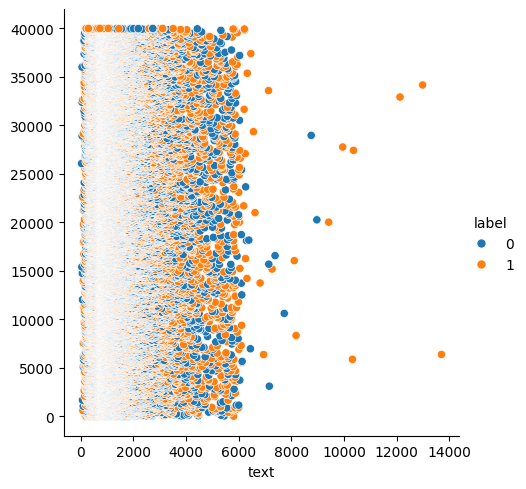

In [9]:
new_Data=data.copy()
for x in data.index:
  new_Data.loc[x,"text"]=len(str(new_Data.loc[x,"text"]))
new_Data.head()

sns.relplot(x="text",y=np.arange(1,40001),hue="label",data=new_Data)

new_Data.corr()

From the .corr() function, it can be seen there is very weak dependance between length of review and its equivalent sentiment.

#Pre-Processing

For preprocessing the data, so it is in a simpler and easier form for the model to read, removing all unneccssary elements such as noise and stop words that might affect the efficiency of our model

In [10]:
import spacy
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words -= {"no", "nor","but","not"}

In [12]:
import emoji
import re
import string
emoticon_string = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
    )"""


We index through each string in the dataframe, and perform some operations on them
- remove instances of emojis
- convert all text to lowercase
- remove all punctuation
- ignore stopwords
- lemmatize

In [14]:
for i in data.index:
  text = data.loc[i,"text"]
  text = re.sub(emoticon_string,'',text)
  text = text.lower()
  text = text.translate(str.maketrans('', '', string.punctuation))
  doc = nlp(text)
  filtered_tokens = [token.lemma_ for token in doc if not token.is_stop]
  text = ' '.join(filtered_tokens)
  data.loc[i,"text"] = text
  print(".",end='')


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
list_texts = data["text"].tolist()
list_labels = data["label"].tolist()

In [18]:
training_size = 30000
train_texts = list_texts[0:training_size]
train_labels = list_labels[0:training_size]
test_texts = list_texts[training_size:]
test_labels = list_labels[training_size:]

test/train split ratio I am using is 0.25

#Feature Extraction

 will be using a HashingVectorizer to tokenize the features so it is readable by the model. HashingVectorizer is more scalable for large memory dataframes and is hence more convenient for our case with the 40,000 review data

In [19]:

from sklearn.feature_extraction.text import HashingVectorizer
import gc
vectorizer = HashingVectorizer()

train_matrix = vectorizer.fit_transform(train_texts)
test_matrix = vectorizer.transform(test_texts)
gc.collect()

0

In [ ]:
#used bag of words before, not giving satisfactory results
'''tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_texts)
train_padded = pad_sequences(train_sequences, maxlen=14000, padding = 'post')

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded = pad_sequences(test_sequences, maxlen=14000, padding = "post")
print(train_padded[0])
print(train_padded.shape)
'''

#Model Selection

Used a couple of models to see which one gives us the best f1 score for our data, as different models have different algos, and sometimes one is just much more suited for a given dataset.

In [ ]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(train_matrix, train_labels)


LogisticRegression(random_state=16)

In [21]:
from sklearn import svm
model = svm.SVC(kernel="linear").fit(train_matrix,train_labels)


In [24]:
y_pred = model.predict(test_matrix)
from sklearn.metrics import f1_score
f1_score(test_labels,y_pred)

0.8840236686390532

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(test_labels,y_pred)

print(cm)

[[4342  630]
 [ 546 4482]]


Text(50.722222222222214, 0.5, 'Truth')

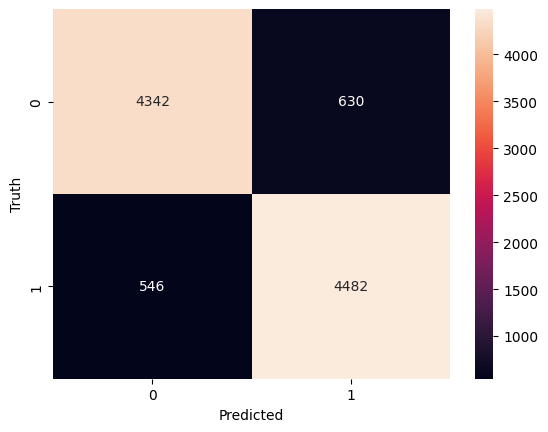

In [26]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

##Other Models

In [20]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
rf = clf.fit(train_matrix,train_labels)


KeyboardInterrupt



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=4)
knn_model=knn.fit(train_matrix,train_labels)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(15000, 16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
import numpy as np
training_padded = np.array(train_padded)
training_labels = np.array(train_labels)
testing_padded = np.array(test_padded)
testing_labels = np.array(test_labels)
print(training_padded.shape)

(28800, 14000)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
900/900 - 40s - 45ms/step - accuracy: 0.4996 - loss: 0.6938 - val_accuracy: 0.4996 - val_loss: 0.6932
Epoch 2/10
900/900 - 39s - 43ms/step - accuracy: 0.4936 - loss: 0.6932 - val_accuracy: 0.5004 - val_loss: 0.6931
Epoch 3/10
900/900 - 39s - 43ms/step - accuracy: 0.4964 - loss: 0.6932 - val_accuracy: 0.4996 - val_loss: 0.6932
Epoch 4/10


KeyboardInterrupt: 